# RNN Hystersis

source: https://towardsdatascience.com/rnn-recurrent-neural-networks-how-to-successfully-model-sequential-data-in-python-5a0b9e494f92

In [ ]:
# import some crap
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, SimpleRNN # for creating regular densely-connected NN layers and RNN layers


import pandas as pd
import numpy as np
import math

import sklearn
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import mean_squared_error, mean_absolute_error # for model evaluation metrics
from sklearn.preprocessing import MinMaxScaler # for feature scaling

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 140

import plotly 
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13051360566957514524
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14390394880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8285205792619669850
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
time_step = 2

In [ ]:
# Use to generate matching plots for poster
def poster_plot(x, actual_y, predicted_y, plot_title, save_name):
    figure = plt.figure(figsize=(14,10))
    plt.plot(x, actual_y, linestyle='--', marker='.', color='blue', label='actual', markersize=8, linewidth=1)
    plt.plot(x, predicted_y, linestyle='--', marker='.', color='red', label='predicted', markersize=8, linewidth=1)
    #plt.scatter(np.transpose(xtest_m19)[2], m19_pred, s=2)
    #plt.xlim(-500, 500)

    plt.xlabel("Magnetic Field H (A/m)", fontsize=22)
    plt.ylabel("Magnetic Flux B (T)", fontsize=22)
    #plt.title("Preisach Neural Network Prediction Results", fontsize=24)
    plt.title(plot_title, fontsize=30)

    plt.legend(loc=2, prop={'size': 24})
    plt.show()

    figure.savefig("./" + save_name, dpi=400)

### Matlab simulated datasets (HB #)

[  0.           1.18095524   2.36348815 ... 230.4581981  245.8529312
 260.4646035 ]
(1188, 2)
(2, 1188)


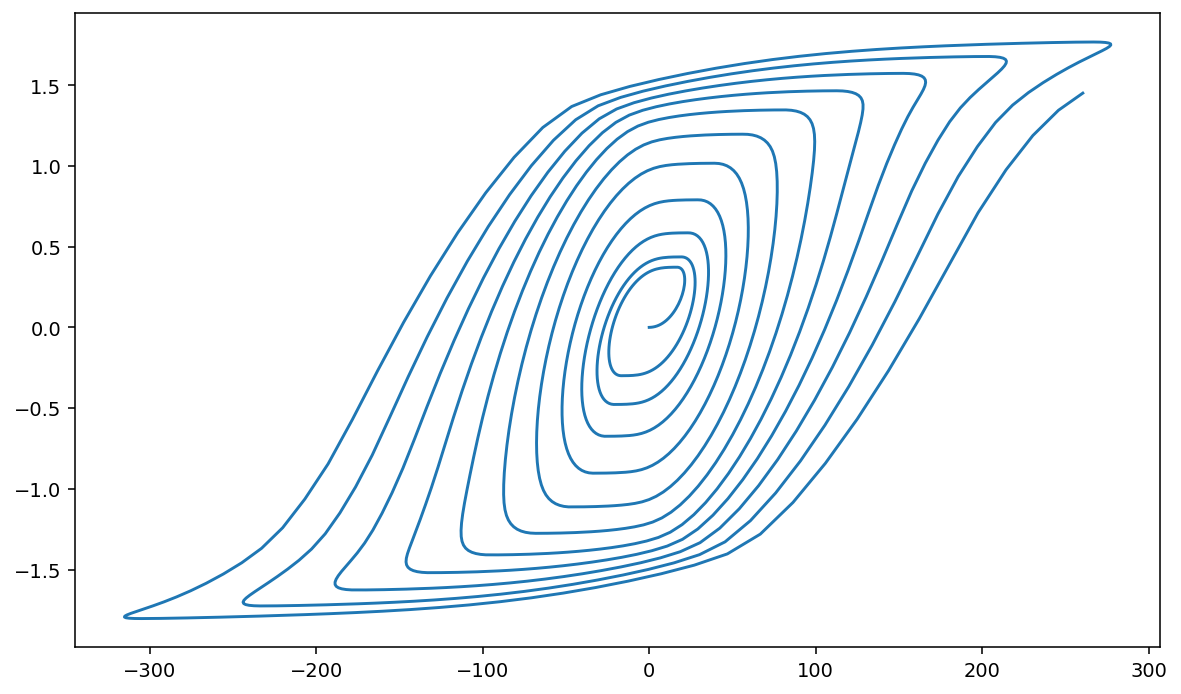

In [ ]:
rawdata = np.genfromtxt("./HB1.csv", delimiter=",")

print(rawdata[:, 0])
print(rawdata.shape)
rawdata = np.transpose(rawdata)
print(rawdata.shape)

plt.plot(rawdata[0], rawdata[1])
plt.show()

In [ ]:
for i in range(len(rawdata[0])):
  #print(str(rawdata[0][i]) + ", " + str(rawdata[1][i]))
  if rawdata[0][i] == 42.31634361:
    print(str(rawdata[0][i]) + ", " + str(rawdata[1][i]))

42.31634361, 0.688579768


In [ ]:
# arranges x into (H_1, H_2 ... H_n) with time_step number of H's
# arranges y to correspond to B_n matching H_n
def prep_data(H_in, B_in, time_step):
  # y array - simply B values (skipping first 'time_step')
  y_tmp = B_in[time_step-1:]

  # x array
  rows_X = len(y_tmp)
  X_tmp = np.zeros(shape=(rows_X, time_step))
  for i in range(time_step, rows_X+time_step):
    row = list()
    for j in range(time_step):
      row.append(H_in[i + j - time_step])
    #print(row)
    X_tmp[i-time_step] = row
    #print(X_tmp[i])

  return X_tmp, y_tmp

#print(rawdata[0])
#print(rawdata[1])
#prep_data(rawdata[0], rawdata[1], 3)

In [ ]:
MAX_DIFF = 200

# Includes previous B values as well as just H values
# arranges x into (H_1, B_1, H_2, B_2 ... H_n) with time_step number of H's
# arranges y to correspond to B_n matching H_n
def prep_data(H_in, B_in, time_step):
  # y array - simply B values (skipping first 'time_step')
  y_tmp = B_in[time_step-1:]

  delete_rows = list()

  # x array
  rows_X = len(y_tmp)
  X_tmp = np.zeros(shape=(rows_X, time_step*2-1))
  for i in range(time_step, rows_X+time_step):
    row = list()

    for j in range(time_step):

      # check if max diff
      #if abs(H_in[i + j - time_step] - H_in[i + j - time_step - 1]) > MAX_DIFF:
      #  row = list()
      #  break

      row.append(H_in[i + j - time_step])
      if j != time_step - 1:
        row.append(B_in[i + j - time_step])
    
    # check if row is valid (ie not empty)
    if len(row) > 0:
      X_tmp[i-time_step] = row
    #else:
    #  # mark to remove row from X and Y arrays
    #  delete_rows.append(i - time_step)

  # delete bad rows
  #for i in delete_rows:
  #  X_tmp = np.delete(X_tmp, (i), axis=0)
  #  y_tmp = np.delete(y_tmp, (i), axis=0)

  return X_tmp, y_tmp

#print(rawdata[0])
#print(rawdata[1])
#prep_data(rawdata[0], rawdata[1], 3)

##### Step 1 + 2 - Scale data, Prep data, and split data into inputs 'x' and outputs 'y'

In [ ]:
def scale_and_split(rawdata, time_step=2, scaler=MinMaxScaler(), shuffle=True):
  """
  Split raw data into x and y. Preps data into sequences with length dependent on time_step
  'rawdata' should be two columns, [H, B]
  Set scaler to None if you want no scaling, otherwise default is MinMaxScaler().
  """
  # Prep data into sequences
  #time_step = 2
  x_total, y_total = prep_data(rawdata[0], rawdata[1], time_step)

  # Scale data
  if scaler is not None:
    x_total = scaler.fit_transform(x_total, y_total)

  # Shuffle
  if shuffle:
    indices = np.arange(x_total.shape[0])
    np.random.shuffle(indices)

    x_total = x_total[indices]
    y_total = y_total[indices]

  return x_total, y_total, scaler

In [ ]:
# Step 1

x_total_HB1, y_total_HB1, scaler_HB1 = scale_and_split(rawdata, time_step=time_step, scaler=MinMaxScaler(), shuffle=False)

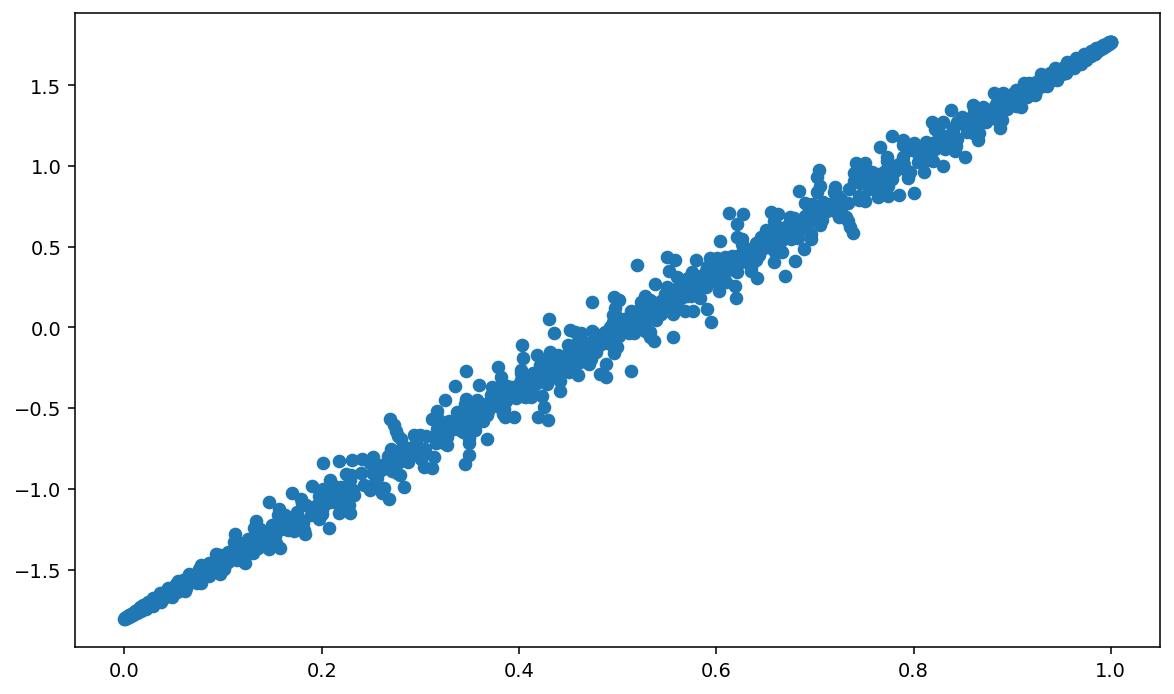

In [ ]:
# Plot (if only using H data as input)
plt.scatter(np.transpose(x_total_HB1)[1], y_total_HB1)
plt.show()

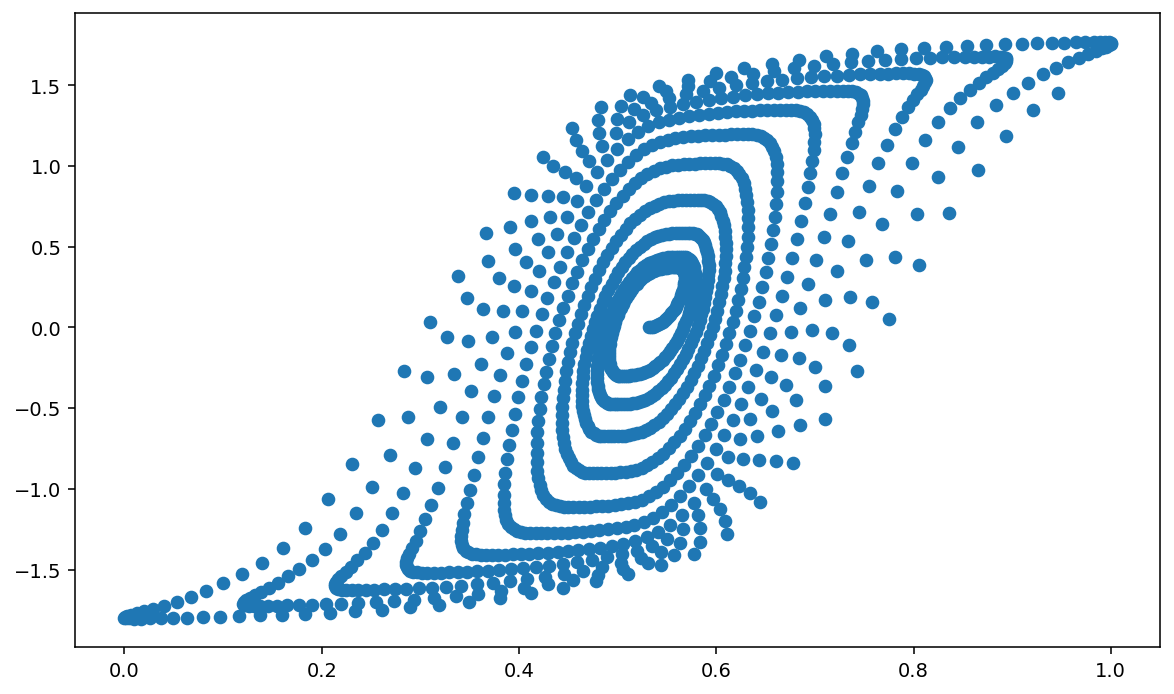

In [ ]:
# if using H and B inputs

plt.scatter(np.transpose(x_total_HB1)[0], y_total_HB1)
plt.show()

##### Step 2b (optional) - additional data

[  0.           1.01240288   2.02709312 ... -60.56545115 -77.87917886
 -95.07675415]
(1188, 2)
(2, 1188)


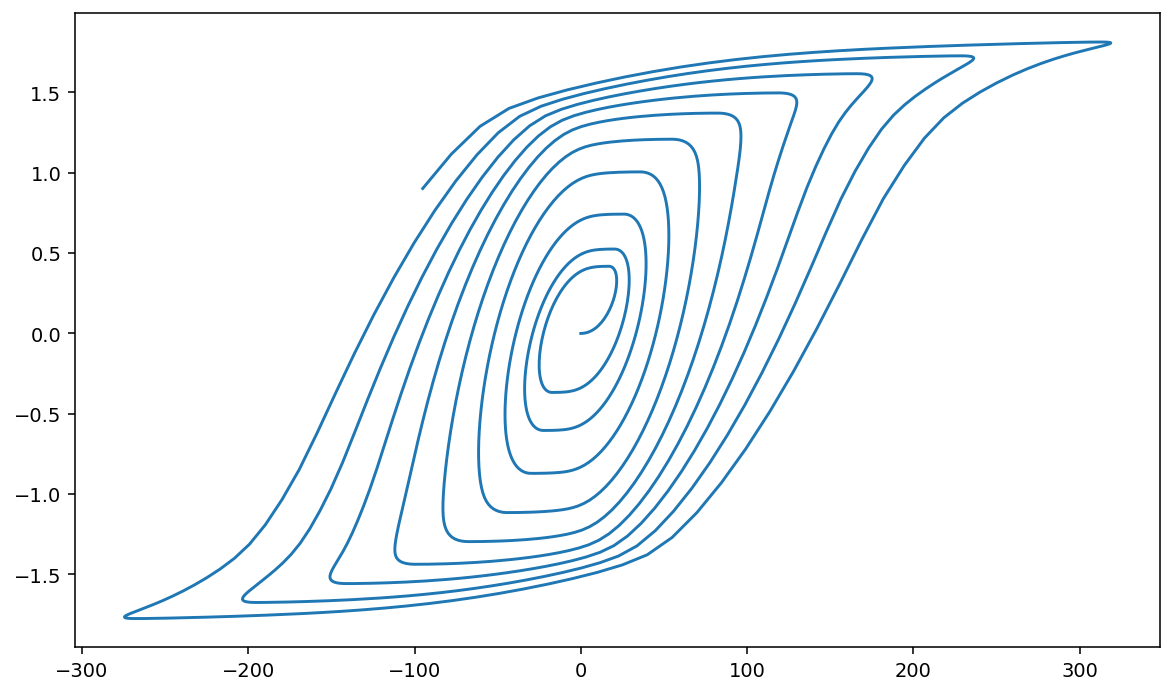

ValueError: ignored

In [ ]:
# get more data

rawdata2 = np.genfromtxt("./HB2.csv", delimiter=",")

print(rawdata2[:, 0])
print(rawdata2.shape)
rawdata2 = np.transpose(rawdata2)
print(rawdata2.shape)

plt.plot(rawdata2[0], rawdata2[1])
plt.show()

x_total_HB2, y_total_HB2 = scale_and_split(rawdata2, time_step=time_step)

plt.scatter(np.transpose(x_total_HB2)[0], y_total_HB2)
plt.show()

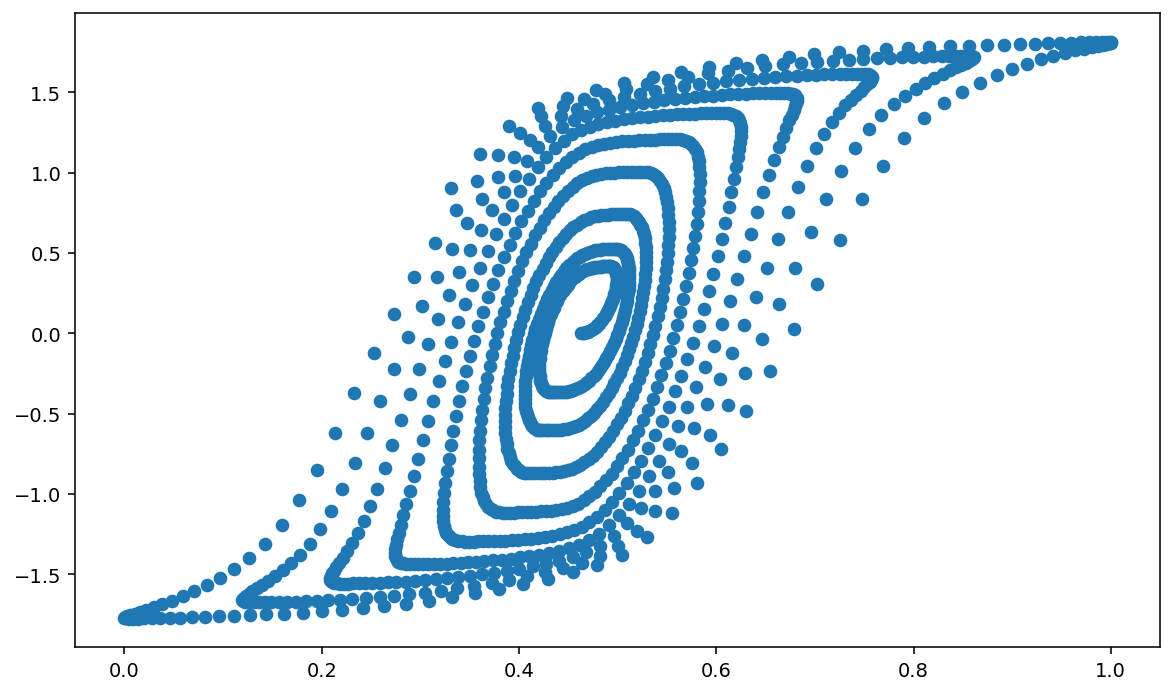

In [ ]:
# If H and B inputs

plt.scatter(np.transpose(x_total2)[0], y_total2)
plt.show()

In [ ]:
x_total = np.concatenate((x_total, x_total2))
y_total = np.concatenate((y_total, y_total2))

print(x_total.shape)
print(y_total.shape)
print(x_total)

NameError: ignored

##### Step 3 - Split into test and training sets

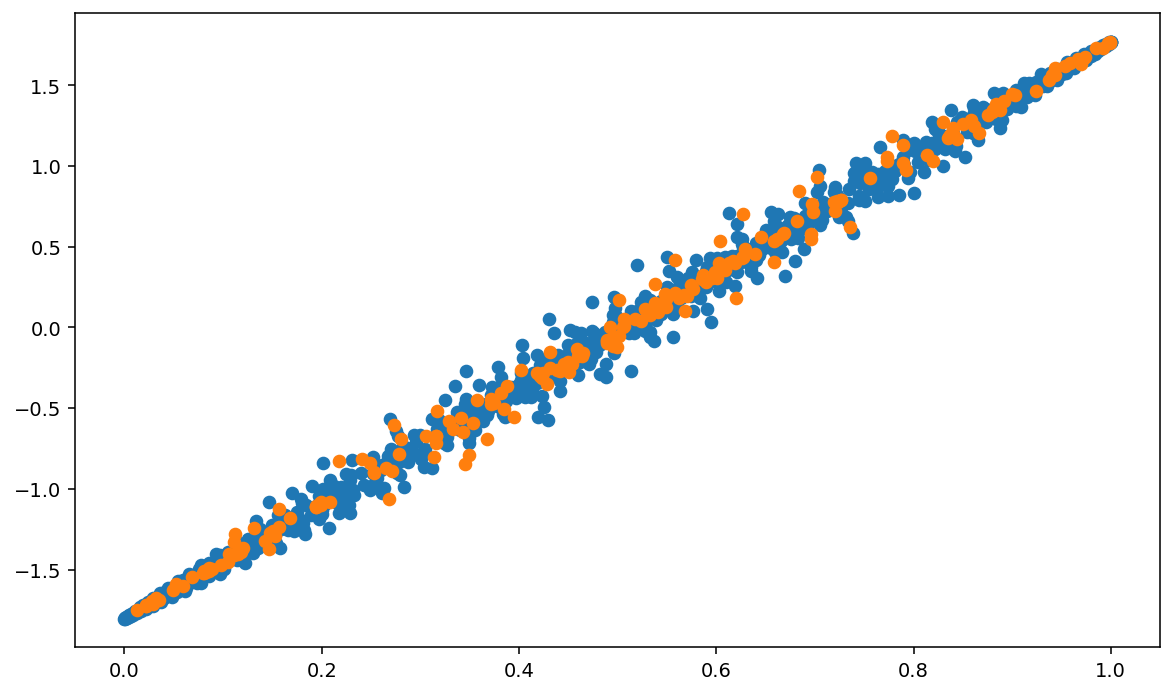

In [ ]:
# Split into test and train
x_train, x_test = train_test_split(x_total_HB1, test_size = 0.2, shuffle=False)
y_train, y_test = train_test_split(y_total_HB1, test_size = 0.2, shuffle=False)

plt.scatter(np.transpose(x_train)[1], y_train)
plt.scatter(np.transpose(x_test)[1], y_test)

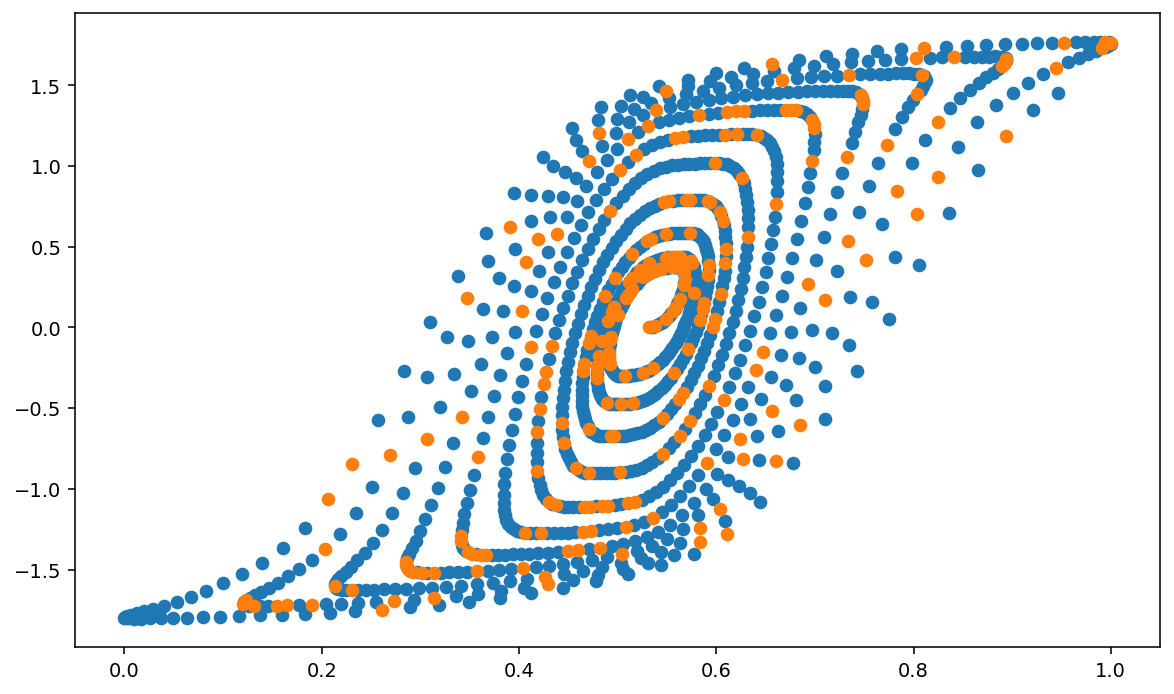

In [ ]:
# if using H and B inputs

plt.scatter(np.transpose(x_train)[0], y_train)
plt.scatter(np.transpose(x_test)[0], y_test)

##### Step 4 - Define structure of neural network

In [ ]:
# if just using H inputs:
#input_size = time_step

# if using both and H and B inputs:
input_size = time_step * 2 - 1 

# Specify structure of neural network
model = Sequential(name="RNN")
model.add(Input(shape=(input_size,1), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs


#model.add(SimpleRNN(units=10, name='Hidden-Recurrent-Layer')) # Hidden Recurrent Layer, Tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x)))
#model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=32, name='Hidden_Recurrent-Layer'))
#model.add(keras.layers.LSTM(units=32, activation='sigmoid', name='Hidden-Recurrent-Layer')) # Hidden Recurrent Layer, Tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x)))
model.add(keras.layers.GRU(units=10))

model.add(Dense(units=32, activation='tanh', name='Hidden-Layer')) # Hidden Layer, Tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x)))
model.add(Dense(units=1, activation='linear', name='Output-Layer')) # Output Layer, Linear(x) = x


##### Step 5 - Compile keras model

In [ ]:
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_absolute_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )


In [ ]:
# "reset" the model by reloading the initial weights:
model.save_weights('model.init')

# and then after training, 
#model.load_weights('model.init')

In [ ]:
model.load_weights('model.init')

##### Step 6 - Fit keras model on the dataset

In [ ]:
model.fit(x_train, # input data
          y_train, # target data
          batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
          epochs=20, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
          verbose='auto', # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
          callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
          validation_split=0.0, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
          #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
          shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
          class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
          sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
          initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
          steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
          validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
          validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
          validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
          max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
          workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
          use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
         )

Epoch 1/20
949/949 [==============================] - 9s 3ms/step - loss: 0.4741 - mean_squared_error: 0.3945 - mean_absolute_error: 0.4741
Epoch 2/20
949/949 [==============================] - 3s 3ms/step - loss: 0.0861 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0861
Epoch 3/20
949/949 [==============================] - 3s 3ms/step - loss: 0.0475 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0475
Epoch 4/20
949/949 [==============================] - 3s 3ms/step - loss: 0.0460 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0460
Epoch 5/20
949/949 [==============================] - 3s 3ms/step - loss: 0.0409 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0409
Epoch 6/20
949/949 [==============================] - 3s 3ms/step - loss: 0.0397 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0397
Epoch 7/20
949/949 [==============================] - 3s 3ms/step - loss: 0.0406 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0406
Epoch 8/20
949/949 [

##### Step 7 - Use model to make predictions

8/8 [==============================] - 0s 2ms/step


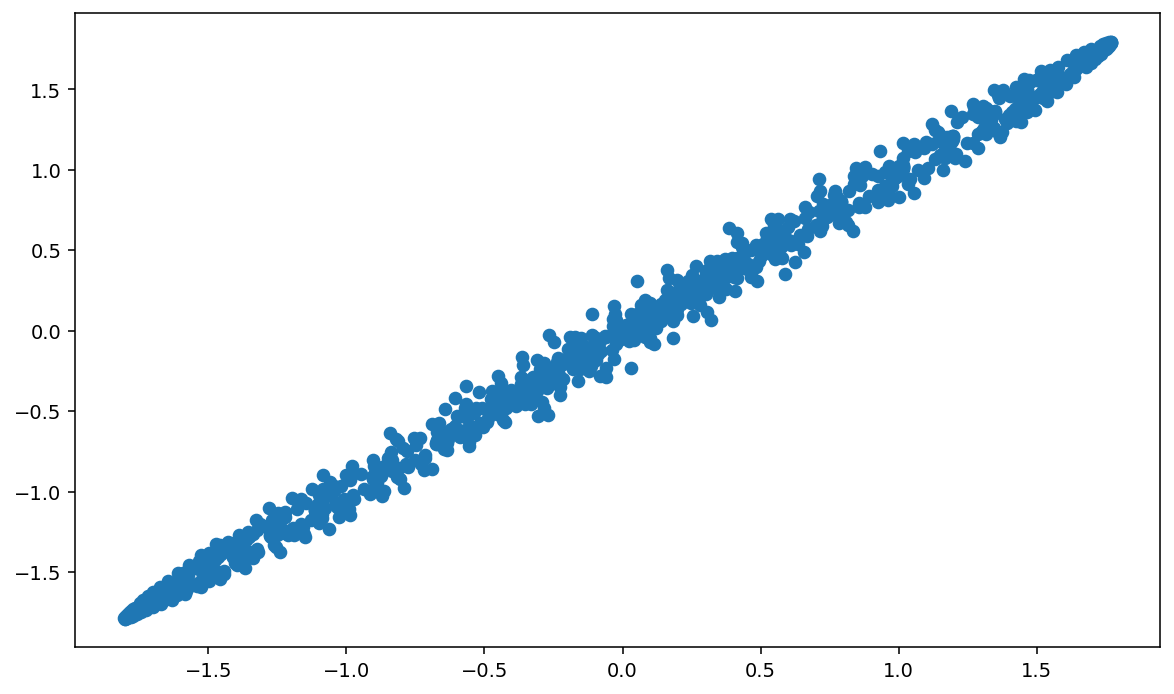

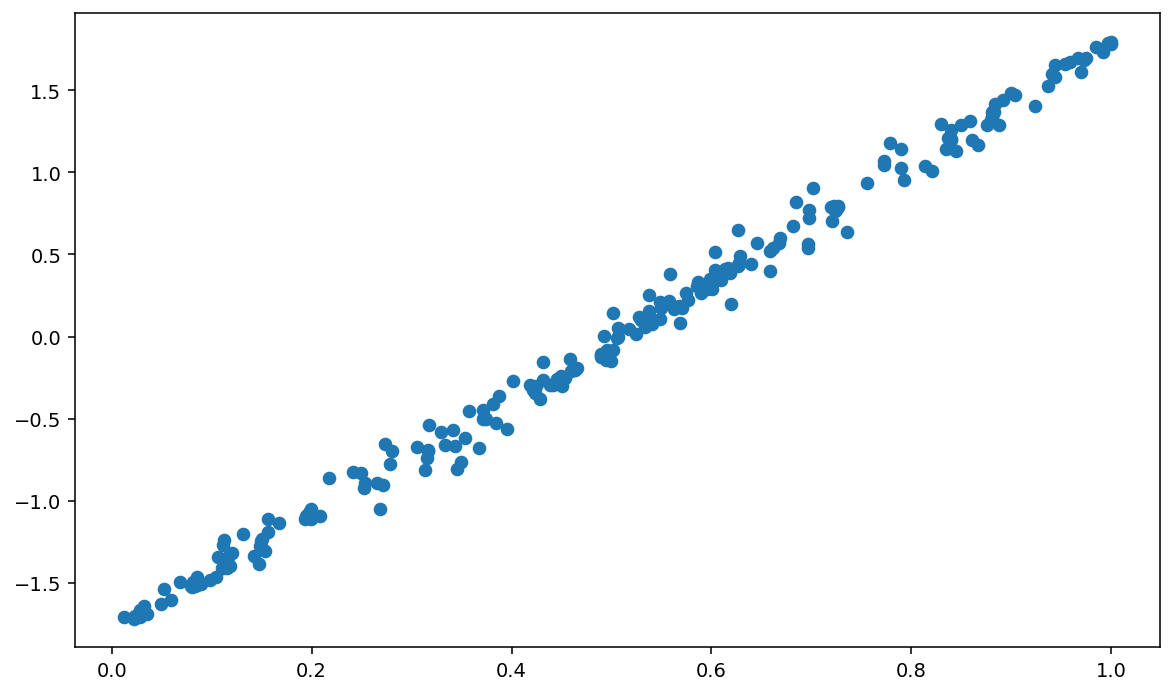

In [ ]:
# Only H inputs

# Predict the result on training data
pred_train = model.predict(x_train)
# Predict the result on test data
pred_test = model.predict(x_test)

# plot train predictions
plt.scatter(np.transpose(scaler_HB1.inverse_transform(x_train))[1], pred_train)
#plt.scatter(np.transpose(x_train)[1], y_train)
plt.show()

# plot test predictions
plt.scatter(np.transpose(x_test)[1], pred_test)
plt.show()

8/8 [==============================] - 0s 2ms/step


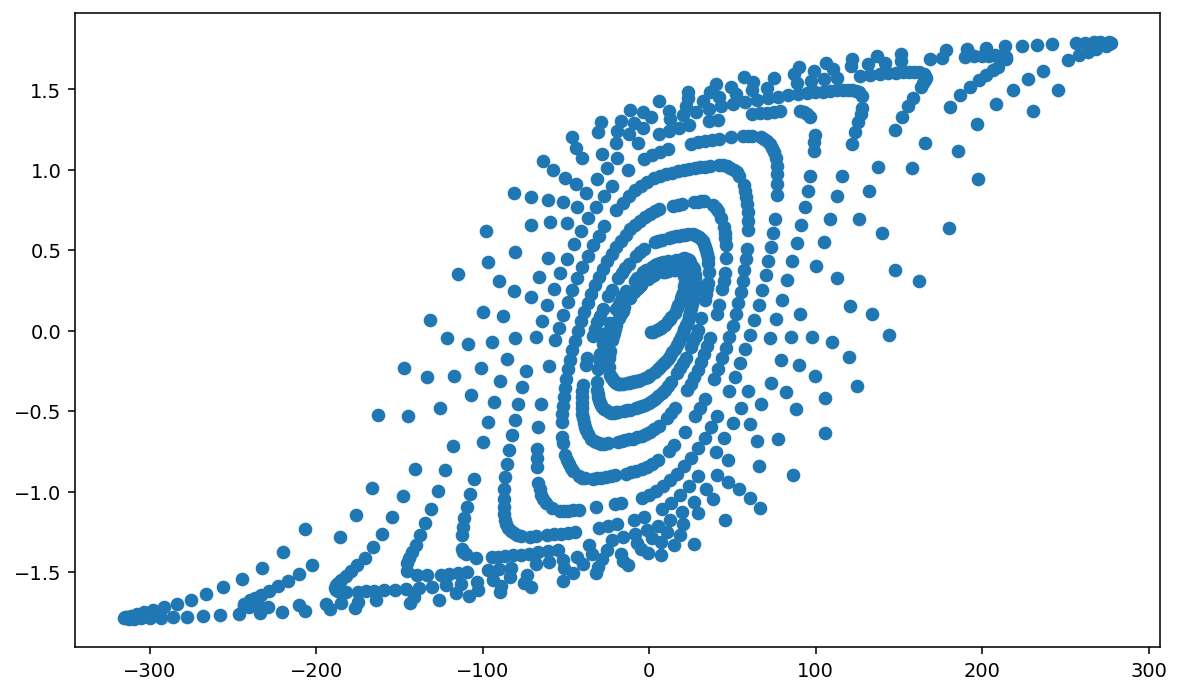

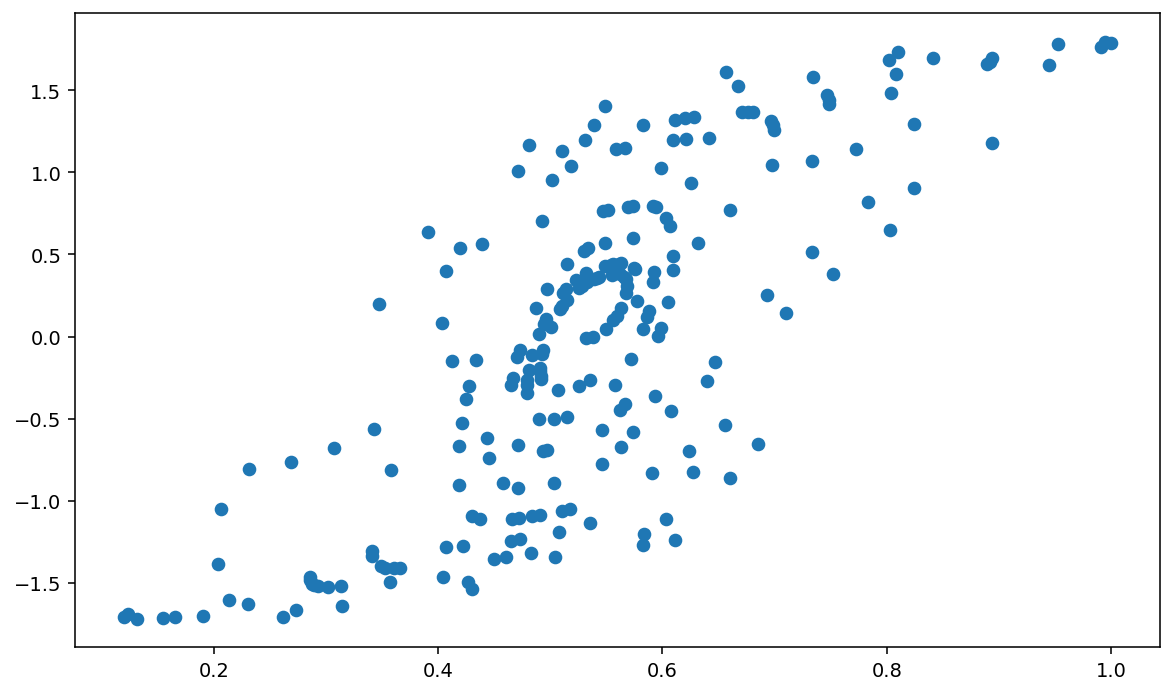

In [ ]:
# H and B inputs

# Predict the result on training data
pred_train = model.predict(x_train)
# Predict the result on test data
pred_test = model.predict(x_test)

# plot train predictions
plt.scatter(np.transpose(scaler_HB1.inverse_transform(x_train))[0], pred_train)
#plt.scatter(np.transpose(x_train)[1], y_train)
plt.show()

# plot test predictions
plt.scatter(np.transpose(x_test)[0], pred_test)
plt.show()

##### Step 8 - Model Performance Summary

In [ ]:

print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary

"""
print("")
print('-------------------- Weights and Biases --------------------')
print("Note, the last parameter in each layer is bias while the rest are weights")
print("")
for layer in model.layers:
    print(layer.name)
    for item in layer.get_weights():
        print("  ", item)
print("")
"""

print('---------- Evaluation on Training Data ----------')
print("MSE: ", mean_squared_error(y_train, pred_train))
print("MAE: ", mean_absolute_error(y_train, pred_train))
print("")

print('---------- Evaluation on Test Data ----------')
print("MSE: ", mean_squared_error(y_test, pred_test))
print("MAE: ", mean_absolute_error(y_test, pred_test))
print("")


-------------------- Model Summary --------------------
Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Recurrent-Layer (CuD  (None, 32)               4480      
 NNLSTM)                                                         
                                                                 
 Hidden-Layer (Dense)        (None, 32)                1056      
                                                                 
 Output-Layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________
---------- Evaluation on Training Data ----------
MSE:  0.000594363197988402
MAE:  0.018680941384256987

---------- Evaluation on Test Data ----------
MSE:  0.0004890627916758413
MAE:  0.017635830081086

##### Predict HB 2 from training on HB 1

In [ ]:
# Predict new dataset
pred2 = model.predict(x_total2)

# plot test predictions
plt.scatter(np.transpose(x_total2)[0], pred2)
plt.show()

print('---------- Evaluation on HB 2 Data ----------')
print("MSE: ", mean_squared_error(y_total2, pred2))
print("MAE: ", mean_absolute_error(y_total2, pred2))
print("")

NameError: ignored

### Bonus step - Train on HB_Comb (2-5), Test on HB 1

In [ ]:
HBs = ["HB2.csv", "HB3.csv", "HB4.csv", "HB5.csv"]

cx_total = np.empty((0,time_step*2-1), np.float32)
cy_total = np.empty((0), np.float32)

for x in HBs:
  raw = np.genfromtxt(x, delimiter=",")
  # Transpose
  raw = np.transpose(raw)

  x, y, _ = scale_and_split(raw, time_step=time_step, scaler=None)

  cx_total = np.concatenate((cx_total, x))
  cy_total = np.concatenate((cy_total, y))

print(cx_total.shape)
print(cy_total.shape)


# scaler after combined
scaler_HBs = MinMaxScaler()
cx_total = scaler_HBs.fit_transform(cx_total, cy_total)


# Plot
#plt.scatter(np.transpose(cx_total)[0], cy_total)
#plt.show()

(4748, 3)
(4748,)


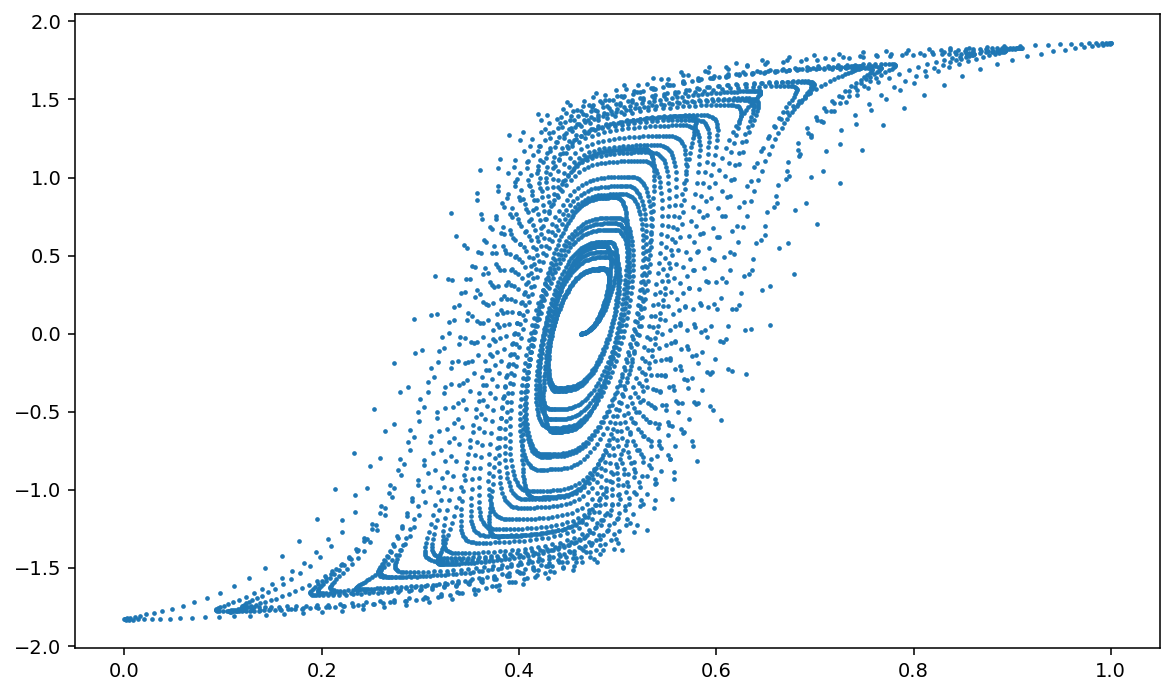

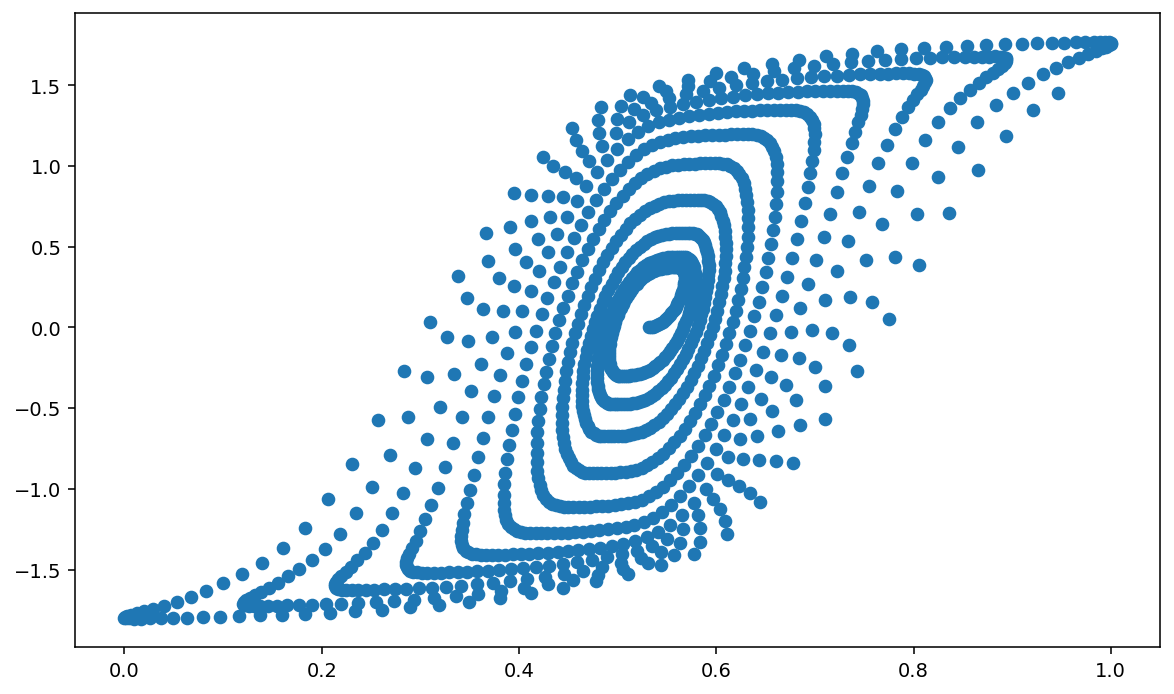

In [ ]:
plt.scatter(np.transpose(cx_total)[0], cy_total, s=2)
plt.show()
plt.scatter(np.transpose(x_total_HB1)[0], y_total_HB1)
plt.show()

In [ ]:
for i in range(len(cx_total)):
  if cx_total[i][0] > 200 and cy_total[i] < 0.5 and cy_total[i] > -0.5:  
    print(cx_total[i])
    print(cy_total[i])

In [ ]:
model.load_weights('model.init')

In [ ]:
model.fit(cx_total, # input data
          cy_total, # target data
          batch_size=32, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
          epochs=20, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
          verbose='auto', # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
          callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
          validation_split=0.0, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
          #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
          shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
          class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
          sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
          initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
          steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
          validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
          validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
          validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
          max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
          workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
          use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
         )

Epoch 1/20
149/149 [==============================] - 2s 4ms/step - loss: 0.7355 - mean_squared_error: 0.8004 - mean_absolute_error: 0.7355
Epoch 2/20
149/149 [==============================] - 1s 4ms/step - loss: 0.2136 - mean_squared_error: 0.0755 - mean_absolute_error: 0.2136
Epoch 3/20
149/149 [==============================] - 1s 4ms/step - loss: 0.0744 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0744
Epoch 4/20
149/149 [==============================] - 1s 4ms/step - loss: 0.0299 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0299
Epoch 5/20
149/149 [==============================] - 1s 4ms/step - loss: 0.0238 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0238
Epoch 6/20
149/149 [==============================] - 1s 4ms/step - loss: 0.0234 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0234
Epoch 7/20
149/149 [==============================] - 1s 4ms/step - loss: 0.0217 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0217
Epoch 8/20
149/149 [

38/38 [==============================] - 0s 2ms/step


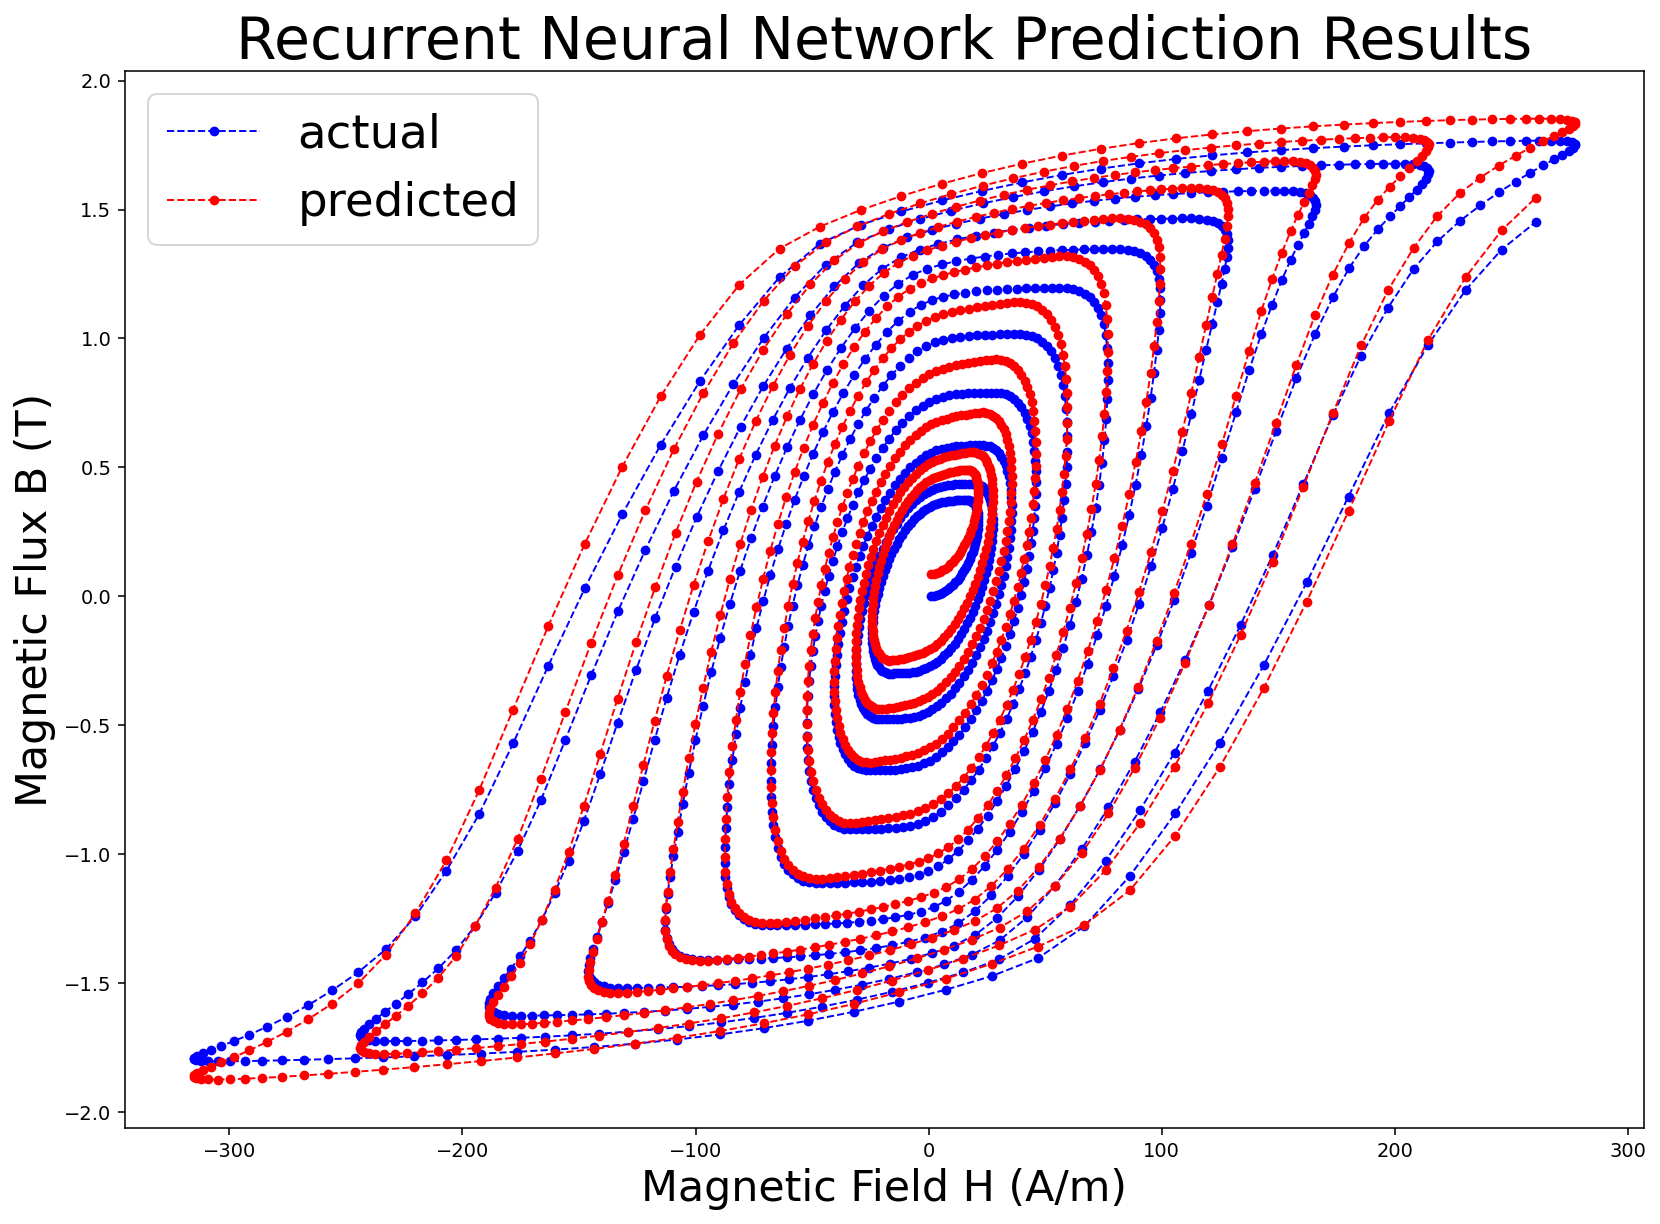

In [ ]:
# Predict the result on HB1 data
#comb_pred = model.predict(scaler.inverse_transform(x_total))
comb_pred = model.predict(x_total_HB1)

# plot predictions
#plt.scatter(np.transpose(scaler.inverse_transform(x_total))[0], comb_pred)
#plt.scatter(np.transpose(x_total_HB1)[0], comb_pred)

# plot predictions


"""
fig = plt.figure()

plt.plot(np.transpose(scaler_HB1.inverse_transform(x_total_HB1))[time_step*2-2], y_total_HB1, linestyle='--', marker='.', color='b', label='actual', markersize=2, linewidth=1)
plt.plot(np.transpose(scaler_HB1.inverse_transform(x_total_HB1))[time_step*2-2], comb_pred, linestyle='--', marker='.', color='red', label='predicted', markersize=2, linewidth=1)
#plt.scatter(np.transpose(xtest_m19)[2], m19_pred, s=2)
#plt.xlim(-500, 500)

plt.xlabel("Magnetic Field H (A/m)", fontsize=18)
plt.ylabel("Magnetic Flux B (T)", fontsize=18)
plt.title("Recurrent Neural Network Prediction Results", fontsize=24)

plt.legend()
plt.show()
fig.savefig('temp.png', dpi=300)
"""
poster_plot(np.transpose(scaler_HB1.inverse_transform(x_total_HB1))[time_step*2-2], y_total_HB1, comb_pred,"Recurrent Neural Network Prediction Results", "temp.png" )

In [ ]:
# Eval
print('---------- Evaluation on HB1 Data after training on HB Comb ----------')
print("MSE: ", mean_squared_error(y_total_HB1, comb_pred))
print("MAE: ", mean_absolute_error(y_total_HB1, comb_pred))
print("")

---------- Evaluation on HB1 Data after training on HB Comb ----------
MSE:  0.006809178543263718
MAE:  0.07390111881306091



### Real material datasets

In [ ]:
m19_time_step = 2

[0.59096613 0.51282022 0.590972  ]
0  : 0.0
2-2: 0.01609999999995397
y  : 7.46e-05
0  : 0.01609999999995397
2-2: 0.07090000000012411
y  : 0.000329
0  : 0.07090000000012411
2-2: 0.1255819999999276
y  : 0.000584
0  : 0.1255819999999276
2-2: 0.1802310000001415
y  : 0.000838
0  : 0.1802310000001415
2-2: 0.23480799999995125
y  : 0.00109
0  : 0.23480799999995125
2-2: 0.289310999999861
y  : 0.00135
0  : 0.289310999999861
2-2: 0.3437409999999228
y  : 0.0016
0  : 0.3437409999999228
2-2: 0.39809899999988463
y  : 0.00186
0  : 0.39809899999988463
2-2: 0.45238399999999857
y  : 0.00211
0  : 0.45238399999999857
2-2: 0.5065970000000125
y  : 0.00237


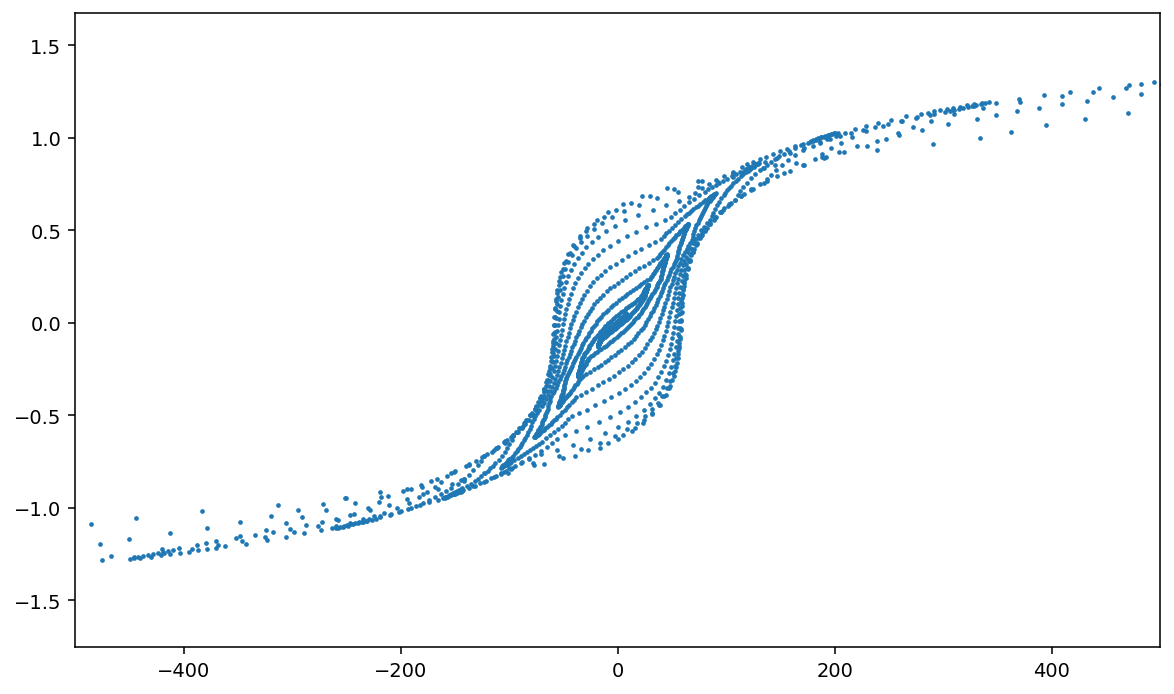

In [ ]:
rawM19 = np.genfromtxt("M19_29Gauge - Sheet1.csv", delimiter=",")

# Extract data from columns 2 and 3
rawM19 = rawM19[:, [2,3]]

# remove first 6 rows, which are not data
rawM19 = rawM19[6:]

rawM19 = np.transpose(rawM19)

x_m19, y_m19, m19_scaler = scale_and_split(rawM19, time_step=m19_time_step, scaler=MinMaxScaler(), shuffle=False)

print(x_m19[0])

for i in range(10):#range(len(m19_scaler.inverse_transform(x_m19))):
  x0 = m19_scaler.inverse_transform(x_m19)[i][0]
  x22 = m19_scaler.inverse_transform(x_m19)[i][m19_time_step*2-2]
  print("0  : " + str(x0))
  print("2-2: " + str(x22))
  print("y  : " + str(y_m19[i]))

plt.scatter(np.transpose(m19_scaler.inverse_transform(x_m19))[m19_time_step*2-2], y_m19, s=2)
plt.xlim(-500, 500)
plt.show()

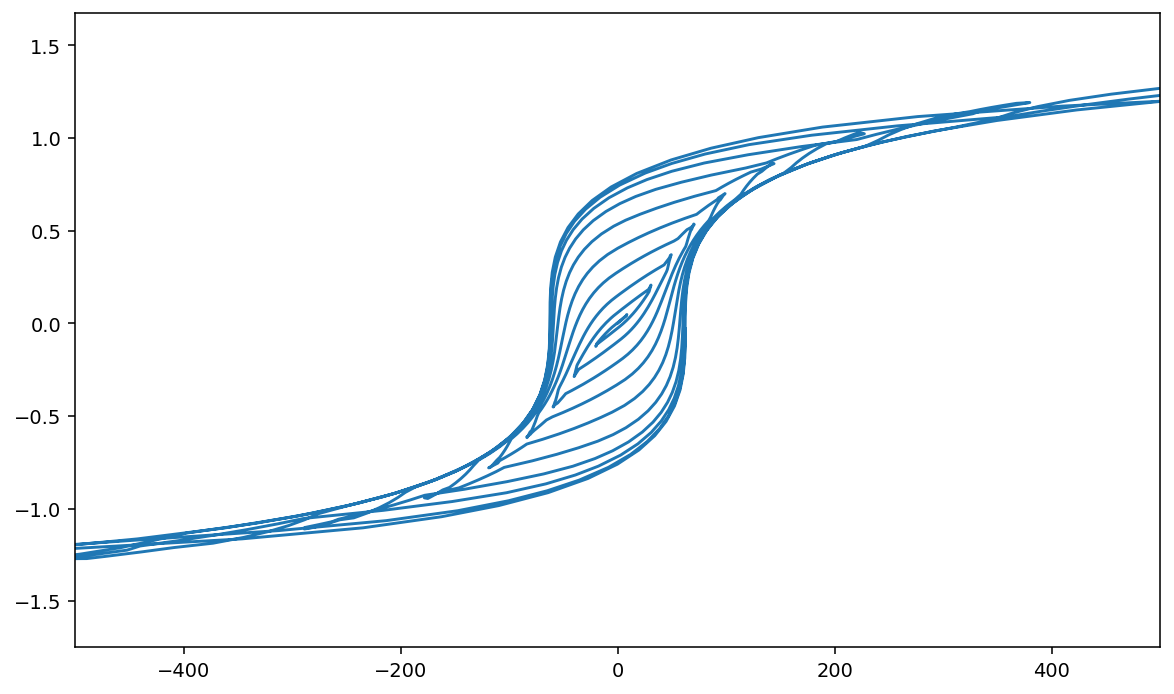

In [ ]:
# load testing data
rawtestM19 = np.genfromtxt("M19_TESTINGDATA - M19_TESTINGDATA.csv", delimiter=",")
# Extract data from columns 2 and 3
rawtestM19 = rawtestM19[:, [2,3]]
# Remove first 6 rows, which are not data
rawtestM19 = rawtestM19[6:]
# Transpose into columns
rawtestM19 = np.transpose(rawtestM19)
# Scale and split
xtest_m19, ytest_m19, m19_scaler = scale_and_split(rawtestM19, time_step=m19_time_step, scaler=m19_scaler, shuffle=False)

plt.plot(np.transpose(m19_scaler.inverse_transform(xtest_m19))[m19_time_step*2-2], ytest_m19)
plt.xlim(-500, 500)
#plt.xlim(0.4, 0.8)
plt.show()

In [ ]:
# if using both and H and B inputs:
input_size = m19_time_step * 2 - 1 

# Specify structure of neural network
model = Sequential(name="RNN")
model.add(Input(shape=(input_size,1), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
#model.add(Dense(units=32, activation='sigmoid'))

#model.add(SimpleRNN(units=10, activation='sigmoid', name='Hidden-Recurrent-Layer')) # Hidden Recurrent Layer, Tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x)))

#model.add(tf.compat.v1.keras.layers.CuDNNLSTM(units=32, name='Hidden_Recurrent-Layer1',return_sequences=True))
#model.add(keras.layers.LSTM(units=32, activation='sigmoid', name='Hidden-Recurrent-Layer')) # Hidden Recurrent Layer, Tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x)))

#model.add(Dense(units=16, activation='tanh', name='Hidden-Layer1')) 

model.add(keras.layers.LSTM(units=16))
model.add(Dense(units=16, activation='tanh', name='Hidden-Layer2')) # Hidden Layer, Tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x)))

model.add(Dense(units=1, activation='linear', name='Output-Layer')) # Output Layer, Linear(x) = x


In [ ]:
model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_absolute_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'MeanAbsoluteError'], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )


In [ ]:
model.fit(x_m19, # input data
          y_m19, # target data
          batch_size=32, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
          epochs=20, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
          verbose='auto', # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
          callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
          validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
          #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
          shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
          class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
          sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
          initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
          steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
          validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
          validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
          validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
          max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
          workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
          use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
         )

Epoch 1/20
50/50 [==============================] - 2s 13ms/step - loss: 0.4100 - mean_squared_error: 0.2751 - mean_absolute_error: 0.4100 - val_loss: 0.8871 - val_mean_squared_error: 0.9682 - val_mean_absolute_error: 0.8871
Epoch 2/20
50/50 [==============================] - 0s 4ms/step - loss: 0.3933 - mean_squared_error: 0.2532 - mean_absolute_error: 0.3933 - val_loss: 0.8107 - val_mean_squared_error: 0.7984 - val_mean_absolute_error: 0.8107
Epoch 3/20
50/50 [==============================] - 0s 4ms/step - loss: 0.3559 - mean_squared_error: 0.2062 - mean_absolute_error: 0.3559 - val_loss: 0.6239 - val_mean_squared_error: 0.4578 - val_mean_absolute_error: 0.6239
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.2424 - mean_squared_error: 0.0980 - mean_absolute_error: 0.2424 - val_loss: 0.2036 - val_mean_squared_error: 0.0738 - val_mean_absolute_error: 0.2036
Epoch 5/20
50/50 [==============================] - 0s 4ms/step - loss: 0.0561 - mean_squared_error: 0.

37/37 [==============================] - 1s 3ms/step
0.027300000000060696
0.027300000000060696
0.000127
[0.06505644]
---
0.1203879999998011
0.1203879999998011
0.00056
[0.0652113]
---
0.21326000000003031
0.21326000000003031
0.000992
[0.06565908]
---
0.3059209999997995
0.3059209999997995
0.00143
[0.06610626]
---


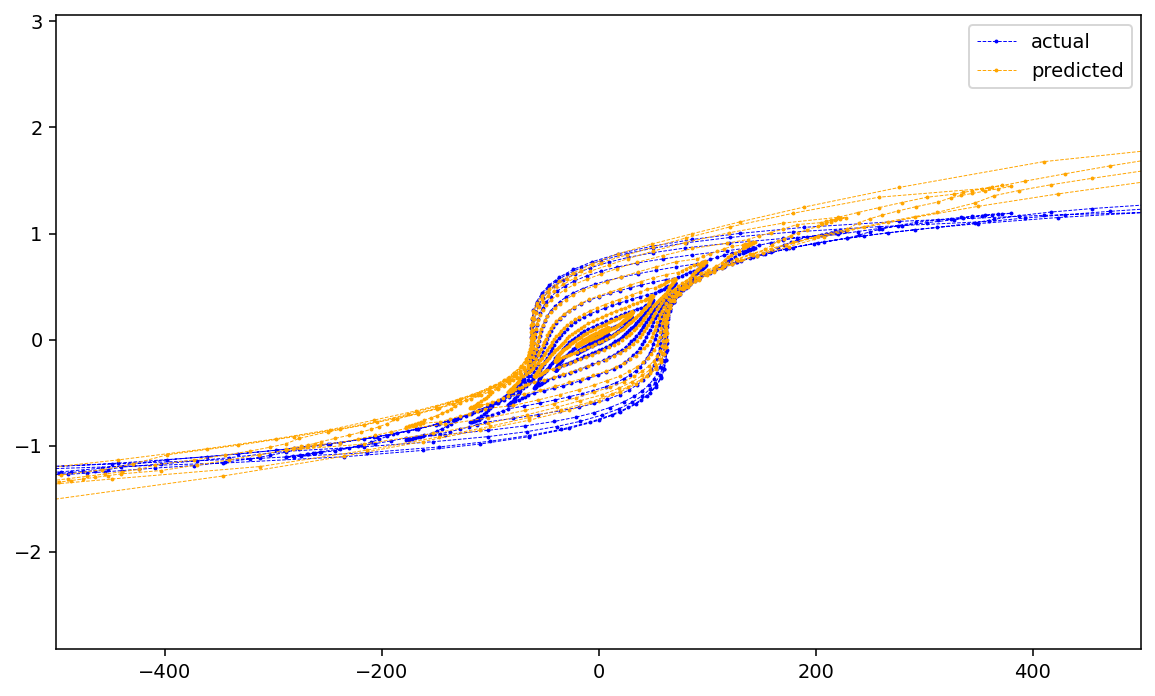

In [ ]:
# Predict the result on HB1 data
#comb_pred = model.predict(scaler.inverse_transform(x_total))
m19_pred = model.predict(xtest_m19)

for i in range(4):
  print(m19_scaler.inverse_transform(xtest_m19)[i][m19_time_step*2-2])
  print(np.transpose(m19_scaler.inverse_transform(xtest_m19))[m19_time_step*2-2][i])
  print(ytest_m19[i])
  print(m19_pred[i])
  print("---")

# plot predictions
plt.plot(np.transpose(m19_scaler.inverse_transform(xtest_m19))[m19_time_step*2-2], ytest_m19, linestyle='--', marker='.', color='b', label='actual', markersize=2, linewidth=0.5)
plt.plot(np.transpose(m19_scaler.inverse_transform(xtest_m19))[m19_time_step*2-2], m19_pred, linestyle='--', marker='.', color='orange', label='predicted', markersize=2, linewidth=0.5)
#plt.scatter(np.transpose(xtest_m19)[2], m19_pred, s=2)
plt.xlim(-500, 500)

plt.legend()
plt.show()


In [ ]:
# Eval
print('---------- Evaluation on M19 testing data ----------')
print("MSE: ", mean_squared_error(ytest_m19, m19_pred))
print("MAE: ", mean_absolute_error(ytest_m19, m19_pred))
print("")

---------- Evaluation on M19 testing data ----------
MSE:  0.0012723381903137583
MAE:  0.027137081217965233



### OTher

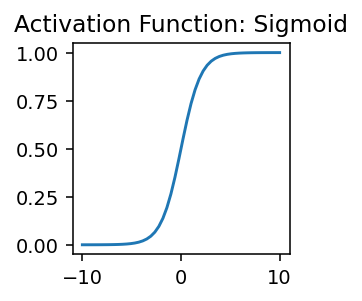

In [ ]:
x = np.linspace(-10, 10)
fig = plt.figure(figsize = (2,2))
plt.plot(x, keras.activations.sigmoid(x))
plt.axis('tight')
plt.title('Activation Function: Sigmoid')
plt.show()

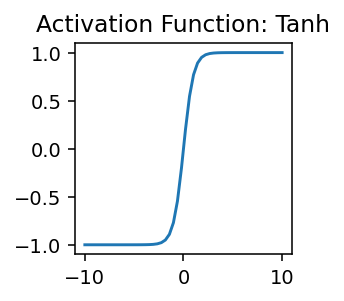

In [ ]:
x = np.linspace(-10, 10)
fig = plt.figure(figsize = (2,2))
plt.plot(x, keras.activations.tanh(x))
plt.axis('tight')
plt.title('Activation Function: Tanh')
plt.show()